# Figure 2: Do LLMs replicate the sparsity effect?

In [2]:
import yaml
import random
import json
import pandas as pd
import seaborn as sns
import numpy as np
import typing
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce

# import kendall_w.kendall_w as kw
import scipy.stats
from tqdm.auto import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import math
import statsmodels.api as sm

# import seaborn_image as isns

sns.set_theme()

In [3]:
def ECDF_transform(arr: np.ndarray):
    return ECDF(arr)(arr)

### Data-loading function

In [6]:
obs = (
    pd.read_pickle("./simulate-comb-A-N/matrix.pkl")[:1_000, :1_000]
    .todense()
    .reshape(-1)
)

In [8]:
adj_freq = pd.read_pickle("./simulate-comb-A-N/adj_freqs.pkl")
noun_freq = pd.read_pickle("./simulate-comb-A-N/noun_freqs.pkl")

In [4]:
def get_results(
    model="gpt2_xl",
    study="composlang",
    paradigm="logprobs",
    basedir=Path("./llm-results/"),
):
    print(f"model={model}, study={study}, paradigm={paradigm}")

    [resultsdir] = (basedir / study).glob("benchmark-cfg=*")
    results = list(resultsdir.glob(f"eval={paradigm}*/model={model}/results.csv"))
    results = [pd.read_csv(r, index_col=0) for r in results]
    if len(results) == 2:
        results = pd.merge(*results)
    elif len(results) == 1:
        results = results[0]
    else:
        raise ValueError(f"Found {len(results)} results")

    results = results[(results.arank >= 0) & (results.nrank >= 0)]

    if paradigm == "logprobs":
        levels = ("metadata", "model")
        model_columns = ["logp_A", "logp_N", "logp_N_A"]
        metadata_columns = results.columns.difference(model_columns)

        mii = pd.MultiIndex.from_tuples(
            tuples=[("metadata", c) for c in results.columns if c in metadata_columns]
            + [("model", c) for c in results.columns if c in model_columns],
            # names=levels,
        )
        results.columns = mii
        results["metadata", "model"] = model

        col = "logp_N_A"
        ecdf = ECDF_transform(results["model", col])
        results["model", f"ecdf_{col}"] = ecdf

        results["model", "pmi"] = (
            results["model", "logp_N_A"] - results["model", "logp_N"]
        ) / math.log(2)

        results["metadata", "observed"] = obs
        results["metadata", "adj_freq"] = results["metadata", "adjective"].map(adj_freq)
        results["metadata", "noun_freq"] = results["metadata", "noun"].map(noun_freq)

    else:
        raise NotImplementedError(f"paradigm={paradigm}!=logprobs")

    return results.sort_index(axis=1)

In [10]:
models = ["gpt2_xl", "phi_2", "mpt_7b", "mpt_7b_chat", "mistral7b", "mpt30b"]

In [9]:
gpt2xl = get_results(model="gpt2_xl")
phi2 = get_results(model="phi_2")
mpt7b = get_results(model="mpt_7b")
mpt7bchat = get_results(model="mpt_7b_chat")
mpt30b = get_results(model="mpt_30b")
# mpt30bchat = get_results(model="mpt_30b_chat")
mistral7b = get_results(model="Mistral_7B_v0.1")

model=gpt2_xl, study=composlang, paradigm=logprobs
model=phi_2, study=composlang, paradigm=logprobs
model=mpt_7b, study=composlang, paradigm=logprobs
model=mpt_7b_chat, study=composlang, paradigm=logprobs
model=mpt_30b, study=composlang, paradigm=logprobs
model=Mistral_7B_v0.1, study=composlang, paradigm=logprobs


In [12]:
mpt7bchat.sample(4)

metadata                                                          \
       adj_freq   adjective arank        model     noun noun_freq nrank   
137630    52141        main   117  mpt_7b_chat     salt     32377   603   
334627    21090        arab   314  mpt_7b_chat  content     32657   600   
196607    36323  democratic   176  mpt_7b_chat   models     33513   580   
518936    11794       about   498  mpt_7b_chat    birds     23317   909   

                        model                                        
       observed ecdf_logp_N_A     logp_A  logp_N logp_N_A       pmi  
137630        0      0.559708 -10.875000 -13.125 -11.5000  2.344379  
334627        0      0.768894 -14.656250 -12.125 -10.0000  3.065727  
196607        7      0.540379 -11.039062 -13.125 -11.6250  2.164043  
518936        0      0.430810 -10.625000 -13.375 -12.3125  1.532863

In [123]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum()


def compute_fit(
    df,
    model="model",
    metric="logp_N_A",
    lower_pct=0.01,
    upper_pct=0.99,
    flip=False,
    exp=False,
    surp=False,
    normx=True,
    normy=False,
):
    lower_bound = df["metadata", "observed"].quantile(lower_pct)
    upper_bound = df["metadata", "observed"].quantile(upper_pct)

    df = df[
        (df["metadata", "observed"] < upper_bound)
        & (df["metadata", "observed"] > lower_bound)
    ]

    y = df["metadata", "observed"]
    if isinstance(metric, str):
        x = df[model, metric]
    else:
        x = df[model, metric[0]] * df[model, metric[1]]

    if surp:
        x = -x
    if exp:
        x = np.exp(x)
    if normx:
        # x = (x - x.min()) / (x.max() - x.min())
        x /= abs(x.sum())

    if normy:
        # y = (y - y.min()) / (y.max() - y.min())
        y /= abs(y.sum())
    if flip:
        x, y = y, x
    model = sm.OLS(y, sm.add_constant(x))
    fit = model.fit()
    return x, y, fit


x, y, fit = compute_fit(mpt30b, flip=True, normy=True)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ('model', 'logp_N_A')   R-squared:                       0.102
Model:                               OLS   Adj. R-squared:                  0.102
Method:                    Least Squares   F-statistic:                 3.715e+04
Date:                   Tue, 23 Jan 2024   Prob (F-statistic):               0.00
Time:                           01:34:09   Log-Likelihood:             4.2386e+06
No. Observations:                 326466   AIC:                        -8.477e+06
Df Residuals:                     326464   BIC:                        -8.477e+06
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -3.173e-06   1.13e-09  -2811.360      0.000   -3.18e-06   -3.17e-06
('metadata', 'observed')     0.0360      0.000    192.739      0.000       0.036       0.036
==============================================================================
Omnibus:                     7405.402   Durbin-Watson:                   1.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10087.046
Skew:                          -0.274   Prob(JB):                         0.00
Kurtosis:                       3.664   Cond. No.                     1.92e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

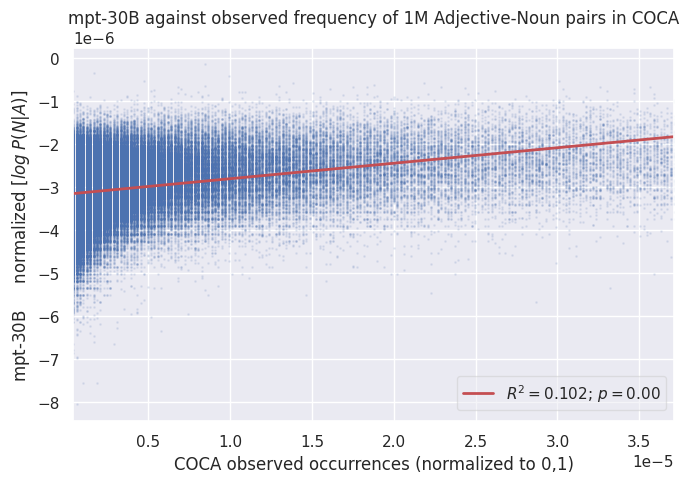

In [124]:
f, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x, y, alpha=0.1, s=1, c="b")
# ax.set_yscale("log")
# ax.set_yscale("log")
# extract intercept b and slope m
b, m = fit.params
# plot y = m*x + b
ax.axline(
    xy1=(0, b),
    # xy2=(1, m + b),
    color="r",
    linewidth=2,
    linestyle="-",
    slope=m,
    # label=f"$y = {m:.1f}x {b:+.1f}$; $R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
    label=f"$R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
)
ax.set_xlim(min(x), max(x))
# ax.set_ylim(1e-0, max(y) + 1)
ax.legend(loc="lower right", bbox_to_anchor=(1, 0.01), framealpha=0.5)
ax.set_title("mpt-30B against observed frequency of 1M Adjective-Noun pairs in COCA")
ax.set_ylabel("mpt-30B $\quad$ normalized $[log\; P(N|A)]$")
ax.set_xlabel("COCA observed occurrences (normalized to 0,1)")

plt.tight_layout()
plt.show()

In [61]:
models = {
    "gpt2xl": gpt2xl,
    "phi2": phi2,
    "mpt7b": mpt7b,
    "mpt7bchat": mpt7bchat,
    "Mistral-7B-v0.1": mistral7b,
    "mpt30b": mpt30b,
}

In [65]:
results = []
for model in models:
    x, y, fit = compute_fit(models[model])
    r2 = fit.rsquared
    p = fit.pvalues[1]
    results.append({"model": model, "r2": r2, "p": p})
    print(
        model,
        f"{fit.rsquared=:.4f}, {fit.pvalues[1]=:.3f}; eqn: y = {fit.params[1]:.3f}x + {fit.params[0]:.3f}",
    )

gpt2xl fit.rsquared=0.0840, fit.pvalues[1]=0.000; eqn: y = 4.163x + 54.250
phi2 fit.rsquared=0.0914, fit.pvalues[1]=0.000; eqn: y = 3.836x + 52.487
mpt7b fit.rsquared=0.0938, fit.pvalues[1]=0.000; eqn: y = 4.327x + 55.110
mpt7bchat fit.rsquared=0.0743, fit.pvalues[1]=0.000; eqn: y = 2.786x + 44.676
Mistral-7B-v0.1 fit.rsquared=0.0729, fit.pvalues[1]=0.000; eqn: y = 3.383x + 47.680
mpt30b fit.rsquared=0.1022, fit.pvalues[1]=0.000; eqn: y = 4.503x + 57.049


In [66]:
*_, fit = compute_fit(
    mpt7bchat,
    model="metadata",
    metric=["adj_freq", "noun_freq"],
    lower_pct=0,
    upper_pct=1,
)
print(
    f"{fit.rsquared=:.4f}, {fit.pvalues.to_list()[1]=:.3f}; eqn: y = {fit.params.to_list()[1]:.3f}x + {fit.params.to_list()[0]:.3f}"
)
results.append(
    {"model": "adj_freq * noun_freq", "r2": fit.rsquared, "p": fit.pvalues.to_list()[1]}
)

fit.rsquared=0.0914, fit.pvalues.to_list()[1]=0.000; eqn: y = 0.000x + -1.654


In [67]:
results = pd.DataFrame(results)
results["model"] += results["p"].apply(lambda val: " (*)" if val < 0.05 else "")
results

,model,r2,p
0,gpt2xl (*),0.084016,0.0
1,phi2 (*),0.091435,0.0
2,mpt7b (*),0.093769,0.0
3,mpt7bchat (*),0.074303,0.0
4,Mistral-7B-v0.1 (*),0.072868,0.0
5,mpt30b (*),0.102165,0.0
6,adj_freq * noun_freq (*),0.091371,0.0


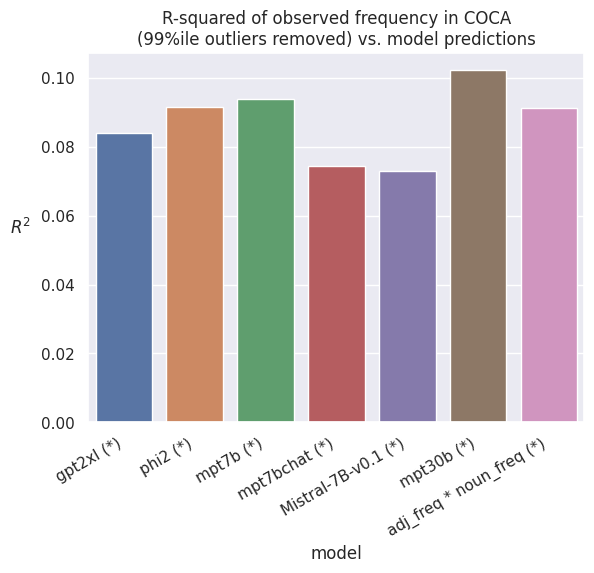

In [134]:
ax = sns.barplot(
    x=results["model"],
    y=results["r2"],
)
# ax.set_xlim(0, 0.1)
# rotate xaxis labels
plt.xticks(rotation=30, ha="right")
plt.title(
    "R-squared of observed frequency in COCA\n(99%ile outliers removed) vs. model predictions"
)
plt.ylabel("$R^2$", rotation=0, labelpad=15)
plt.show()

In [138]:
def construct_mat(df, col="logp_N_A"):
    model = df.columns[-1][0]
    mat = np.zeros((1000, 1000))
    for i, row in tqdm(df.iterrows(), total=len(df)):
        mat[row.loc[("metadata", "arank")], row.loc[("metadata", "nrank")]] = row.loc[
            (model, col)
        ]
    return mat

In [139]:
mat_mpt30b = construct_mat(mpt30b)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [141]:
pd.to_pickle(mat_mpt30b, "./simulate-comb-A-N/mat_mpt30b.pkl")

In [143]:
def construct_mat_bayes(df):
    model = df.columns[-1][0]
    mat = np.zeros((1000, 1000))
    for i, row in tqdm(df.iterrows(), total=len(df)):
        mat[row.loc[("metadata", "arank")], row.loc[("metadata", "nrank")]] = (
            row.loc[(model, "logp_N_A")] * row.loc[(model, "logp_A")]
        )
    return mat

In [146]:
mat_mpt30b_bayes = construct_mat_bayes(mpt30b)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [145]:
pd.to_pickle(mat_mpt30b_bayes, "./simulate-comb-A-N/mat_mpt30b_bayes.pkl")